# [E-09] 프로젝트: 폐렴 진단기 성능 개선

[Chest X-Ray Images (Pneumonia)][1]

[1]:https://www.kaggle.com/paultimothymooney/chest-xray-pneumonia
<br/>

#### 의료 영상 분석하기
- 의료 영상 이미지는 개인 정보 보호 등의 이슈로 인해 데이터를 구하는 것이 쉽지 않음
- 라벨링 작업 자체가 전문적 지식을 요하므로 데이터셋 구축 비용이 비쌈
- 희귀질병을 다루는 경우 데이터를 입수하는 것 자체가 드문 일
- 음성/양성 데이터 간 imbalance가 심함. 학습에 주의 필요
- 이미지만으로 진단이 쉽지 않아 다른 데이터와 결합해서 해석해야 할 수도 있음
<br/>

🐙 의료 영상 처리를 위해선 딥러닝 영상 기술 뿐 아니라, **의료 도메인 지식 및 의료 영상에 대한 명확한 이해**가 필요하다!! 🐙`

***

## 🧤 진행 단계
1. 실습환경 set-up
2. 데이터 준비
3. 데이터 시각화
4. cnn 모델링
5. 데이터 imbalance 처리
6. 모델 훈련
7. 결과 확인과 시각화

## 🧤 목표
실습 단계를 개선해 성능을 향상시켜보자.

***

## Step 1. 실험환경 Set-up
> Batch size, epoch 등을 변경해보자.

In [1]:
import os, re
import random, math
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import warnings 
warnings.filterwarnings(action='ignore')

In [2]:
# 데이터 로드를 할 때 빠르게 로드할 수 있도록 하는 설정 변수
AUTOTUNE = tf.data.experimental.AUTOTUNE

# X-RAY 이미지 사이즈 변수
IMAGE_SIZE = [180, 180]

# 데이터 경로 변수
ROOT_PATH = os.path.join(os.getenv('HOME'), 'aiffel')
TRAIN_PATH = ROOT_PATH + '/chest_xray/data/train/*/*' # *은 모든 디렉토리와 파일을 의미합니다.
VAL_PATH = ROOT_PATH + '/chest_xray/data/val/*/*'
TEST_PATH = ROOT_PATH + '/chest_xray/data/test/*/*'

# 프로젝트를 진행할 때 아래 두 변수 변경해보자
BATCH_SIZE = 32
EPOCHS = 35

print(ROOT_PATH)

/aiffel/aiffel


## Step 2. 데이터 준비하기
> 원본 데이터를 가져와 전처리 및 배치 구성을 하는데, 의료 영상 이미지 특성상 데이터는 충분하지 않다. 이를 극복할 수 있는 방법 고민해보자. `augmentation`은 의료 영상인 경우 일반 이미지 처리에서 사용하는 augmentation이 항상 도움된다고 할 수 없다. 의료 영상 특성상, 육안으로도 구분하기 어려운 미묘한 차이에 노이즈를 더하는 부수효과가 오히려 더 방해를 줄 수도 있다.

In [3]:
train_filenames = tf.io.gfile.glob(TRAIN_PATH)
test_filenames = tf.io.gfile.glob(TEST_PATH)
val_filenames = tf.io.gfile.glob(VAL_PATH)

print(len(train_filenames))
print(len(test_filenames))
print(len(val_filenames))

5216
624
16


In [4]:
total_len = len(train_filenames) + len(test_filenames) + len(val_filenames)

print('train 데이터 비율: ', len(train_filenames) / total_len * 100)
print('test 데이터 비율: ', len(test_filenames) / total_len * 100)
print('val 데이터 비율: ', len(val_filenames) / total_len * 100)

train 데이터 비율:  89.07103825136612
test 데이터 비율:  10.655737704918032
val 데이터 비율:  0.273224043715847


> train과 val 데이터를 모은 뒤 train : val을 80:20 으로 분할하자.

In [5]:
# train 데이터와 validation 데이터를 모두 filenames에 담습니다
filenames = tf.io.gfile.glob(TRAIN_PATH)
filenames.extend(tf.io.gfile.glob(VAL_PATH)) # 합치기

# 모아진 filenames를 8:2로 나누기
train_size = math.floor(len(filenames) * 0.8)
random.seed(8)
random.shuffle(filenames)
train_filenames = filenames[:train_size] # train(8)
val_filenames = filenames[train_size:] # val(2)

print(len(train_filenames))
print(len(test_filenames))
print(len(val_filenames))

4185
624
1047


> 정상 이미지 & 폐렴 이미지의 **파일 경로 이름**을 확인해보면 조금 다름을 알 수 있다.

In [6]:
print(f'Normal image path\n{filenames[0]}') # 정상
print(f'Pneumonia image path\n{filenames[2000]}') # 폐렴

Normal image path
/aiffel/aiffel/chest_xray/data/train/NORMAL/NORMAL2-IM-1317-0001.jpeg
Pneumonia image path
/aiffel/aiffel/chest_xray/data/train/PNEUMONIA/person299_bacteria_1418.jpeg


> 파일 경로에 ***NORMAL***이 있음을 확인하면 정상 이미지를 셀 수 있다. 마찬가지로, ***PNEUMONIA***가 있다면 폐렴 이미지일 것이다.

In [7]:
COUNT_NORMAL = len([filename for filename in train_filenames if "NORMAL" in filename])
print(f"Normal images count in training set: {COUNT_NORMAL}")


COUNT_PNEUMONIA = len([filename for filename in train_filenames if "PNEUMONIA" in filename])
print(f"Pneumonia images count in training set: {COUNT_PNEUMONIA}")

Normal images count in training set: 1072
Pneumonia images count in training set: 3113


> - 정상보다 폐렴 이미지가 3배 정도 더 많다. 우리가 사용할 CNN 모델은 데이터가 클래스별 balance가 좋을수록 training을 잘 한다. 이렇게 ***imbalance한 부분은 차후에 조정***할 예정이다. <br/>
> - test와 val 데이터셋은 평가하기 위해 사용되는 것이므로 학습과 관련이 없다. 따라서 imbalance해도 상관 없다.

`tf.data 인스턴스`를 만들어보자. <br/>
- tf.data는 tensorflow에서 학습시킬 때, mini-batch로 작업할 수 있도록 한다. <br/>

참조: https://acdongpgm.tistory.com/202

In [8]:
# dataset을 만들어 넣기
train_list_ds = tf.data.Dataset.from_tensor_slices(train_filenames)
val_list_ds = tf.data.Dataset.from_tensor_slices(val_filenames)

In [9]:
TRAIN_IMG_COUNT = tf.data.experimental.cardinality(train_list_ds).numpy()
print(f"Training images count: {TRAIN_IMG_COUNT}")

VAL_IMG_COUNT = tf.data.experimental.cardinality(val_list_ds).numpy()
print(f"Validating images count: {VAL_IMG_COUNT}")

Training images count: 4185
Validating images count: 1047


> #### ❓ tf.data.experimental.cardinality
> : dataset의 카디널리티를 리턴해줌
> - cardinality: 특정 data 집합의 unique한 값의 개수

> 현재 이미지에는 라벨 데이터가 따로 없다. 파일 경로에 포함된 'NORMAL', 'PNEUMONIA'를 통해 **라벨 데이터를 만들어주는 함수**를 구현해보자.

In [10]:
# 파일 경로의 끝에서 두 번째 부분을 이용하면 양성/음성을 구분할 수 있다.
def get_label(file_path):
    parts = tf.strings.split(file_path, os.path.sep)
    return parts[-2] == "PNEUMONIA" # 폐렴이면 양성(True), 노말이면 음성(False)

> 이미지 사이즈를 통일시키고, GPU를 더 효율적으로 사용하기 위해 이미지 사이즈를 줄여보자. <br/>
- process_path 함수에선 decode_img 함수를 이용해 이미지의 데이터 타입을 float으로 바꾸고 사이즈를 변경한다.
- get_label을 이용해 라벨 값을 가져온다.

In [11]:
# 이미지를 알맞은 형식으로 바꾸자.
def decode_img(img):
    img = tf.image.decode_jpeg(img, channels=3) # JPEG으로 인코딩 된 이미지를 uint8 tensor로 수정(디코딩)
    img = tf.image.convert_image_dtype(img, tf.float32) # float32 타입으로 수정
    img = tf.image.resize(img, IMAGE_SIZE) # 이미지 사이즈를 IMAGE_SIZE(180x180)로 수정
    return img

# 이미지 파일의 경로를 입력하면 이미지와 라벨을 읽어옴
def process_path(file_path):
    label = get_label(file_path) # 라벨 검출
    img = tf.io.read_file(file_path) # 이미지 읽기
    img = decode_img(img) # 이미지를 알맞은 형식으로 수정 (위에서 180x180으로 설정함)
    return img, label

> #### ❓ 왜 굳이 uint8로 디코딩한 이미지를 또 float32로 변경하는가? <br/>
> 이에 대한 궁금증이 있었는데 텐서플로우는 기본적으로 float 형태를 기반으로 한다고 한다. uint8 형으로 코드가 문제 없이 실행되어도 에러가 발생할 수 있는 미연의 방지를 위해 float 형으로 변환한다고 판단했다. <br/>
> 또한 텐서플로우 함수 내부에서 자체적으로 float 형으로 변환하는 코드가 존재하기 때문에 float 형변환 부분을 주석처리해도 문제 없이 resize 된 것으로 보인다.

> train 데이터셋과 validation 데이터셋 만들기. <br/>
> num_parallel_calls 파라미터에 위에서 할당한 **AUTOTUNE 변수**를 이용하면 더욱 빠르게 데이터 처리 할 수 있음 <br/>

> #### ❓ num_parallel_calls
> : 여러 병렬 데이터셋을 불러오고, 파일을 여는데 시간을 단축한다.

In [12]:
train_ds = train_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)
val_ds = val_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)

for image, label in train_ds.take(1): # 하나의 데이터만 가져온다.
    print('Image shape: ', image.numpy().shape)
    print('Label: ', label.numpy())

Image shape:  (180, 180, 3)
Label:  False


> 위에서 train, val 데이터셋 만든 것처럼 test 데이터셋도 만들어보자.

In [13]:
test_list_ds = tf.data.Dataset.list_files(TEST_PATH) # train, val과는 코드가 약간 다름
TEST_IMAGE_COUNT = tf.data.experimental.cardinality(test_list_ds).numpy()
test_ds = test_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)
test_ds = test_ds.batch(BATCH_SIZE) # train, val에는 없던 코드

print(TEST_IMAGE_COUNT)

624


(+) test_ds는 아래에서 구현할 `prepare_for_training()` 함수를 이용하지 않으므로 `batch()`로 따로 나눠준 것 같다.

> TensorFlow에서는 tf.data 파이프라인을 이용해 학습 데이터를 효율적으로 사용할 수 있도록 한다. tf.data 파이프라인을 이용해 **prepare_for_training()** 함수를 정의해 데이터를 변환시켜주자.
- `shuffle()`을 통해 고정 크기 버퍼를 유지하고, 해당 버퍼에서 무작위로 균일하게 다음 요소 선택하자.
- `repeat()`를 사용한 데이터셋의 경우 epoch를 진행할 때 여러 번 데이터셋을 사용할 수 있게 된다.
- `batch()`를 통해 BATCH_SIZE에서 정한 만큼의 배치로 주어지는데, 예를 들어 100개의 데이터를 10개의 배치로 나누게 되면 각 배치에는 10개의 데이터로 나뉘게 된다.
- `prefetch()`를 사용하면 학습 데이터를 나눠서 읽어오기 때문에 첫 번째 데이터를 GPU에서 학습하는 동안 두 번째 데이터를 CPU에서 준비할 수 있어 리소스의 유휴상태를 줄일 수 있다.
> - 유휴 상태: 어떠한 프로그램에 의해서도 사용되지 않는 상태 <br/>
> - prefetch: CPU가 연산을 하는 동안 다음 연산에 필요한 데이터를 유추해서 필요한 data들을 미리 가져오는 것

### 🧤 성능 개선 (1) batch_size 증가 + epoch 증가 + 좌우 반전 augmentation 도입 + Droput 미사용 (80.1%)
- batch_size: 16 -> 32
- epoch: 25 -> 35
- `augment` 함수를 통해 랜덤하게 좌우 반전 시킨다.
- dropout 미사용

In [14]:
def augment(image, label):
    image = tf.image.random_flip_left_right(image)  # 랜덤하게 좌우를 반전합니다.
    return image,label

def prepare_for_training_aug(ds, shuffle_buffer_size=1000):
    # augment 적용 부분이 배치처리 함수에 추가되었습니다.
    ds = ds.map(
            augment,       # augment 함수 적용
            num_parallel_calls=2
        )
    ds = ds.shuffle(buffer_size=shuffle_buffer_size)  # 고정 크기 버퍼 유지
    ds = ds.repeat() # epoch 진행 시 데이터셋 여러 번 사용 가능
    ds = ds.batch(BATCH_SIZE)
    ds = ds.prefetch(buffer_size=AUTOTUNE) # 다음 연산 데이터 미리 가져오기

    return ds

train_ds_aug = prepare_for_training_aug(train_ds)
val_ds_aug = prepare_for_training_aug(val_ds)

## Step 3. 데이터 시각화
만약 augmentation을 시도했다면 `show_bath()`를 통해 실제로 좌우반전이 되었는지 확인해보기

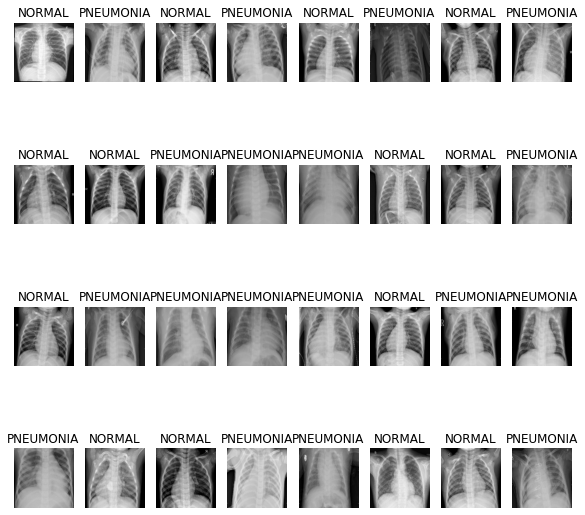

In [15]:
# 이미지 배치를 입력하면 여러 장의 이미지를 보여줌
def show_batch(image_batch, label_batch):
    plt.figure(figsize=(10, 10))
    for n in range(BATCH_SIZE): # BATCH_SIZE=32
        ax = plt.subplot(4, math.ceil(BATCH_SIZE/4), n+1) # (4, 8, n+1)
        plt.imshow(image_batch[n])
        if label_batch[n]: # True면 폐렴
            plt.title("PNEUMONIA")
        else:
            plt.title("NORMAL")
        plt.axis("off")


# train_ds의 label에 True(폐렴)/False(정상) 데이터가 저장되어 있었음.
image_batch_aug, label_batch_aug = next(iter(train_ds_aug))
show_batch(image_batch_aug.numpy(), label_batch_aug.numpy())

> 확인 가능하다.

## Step 4. CNN 모델링
- Convolution filter, 채널 수, activation, 모델 구조 등 다양하게 바꿔보자. <br/>
앞서 batch normalization과 dropout을 한 모델 안에서 동시에 사용하는 구성을 실습했는데, 이는 일반적으로 잘 사용되지 않지만, 이미지 사이즈가 크고 데이터가 부족한 의료 영상에선 간혹 좋은 성능을 보이기도 한다. <br/>
- BatchNormalization을 쓰거나 쓰지 않거나, dropout을 쓰거나 쓰지 않거나
- dropout 비율 변경하기


In [16]:
def conv_block(filters):
    block = tf.keras.Sequential([
        tf.keras.layers.SeparableConv2D(filters, 3, activation='relu', padding='same'),
        tf.keras.layers.SeparableConv2D(filters, 3, activation='relu', padding='same'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPool2D()
    ])
    
    return block

In [17]:
def dense_block(units): # dropout 삭제
    block = tf.keras.Sequential([
        tf.keras.layers.Dense(units, activation='relu'),
        tf.keras.layers.BatchNormalization(),
#         tf.keras.layers.Dropout(dropout_rate)
    ])
    
    return block

In [18]:
def build_model():
    model = tf.keras.Sequential([
        tf.keras.Input(shape=(IMAGE_SIZE[0], IMAGE_SIZE[1], 3)),
        
        tf.keras.layers.Conv2D(16, 3, activation='relu', padding='same'),
        tf.keras.layers.Conv2D(16, 3, activation='relu', padding='same'),
        tf.keras.layers.MaxPool2D(),
        
        conv_block(32),
        conv_block(64),
        
        conv_block(128),
        tf.keras.layers.Dropout(0.2),
        
        conv_block(256),
        tf.keras.layers.Dropout(0.2),
        
        tf.keras.layers.Flatten(),
        dense_block(512), # 변경
        dense_block(128), # 변경
        dense_block(64), # 변경
        
        tf.keras.layers.Dense(1, activation='sigmoid')
    ])
    
    return model

## Step 5. 데이터 imbalance 처리
> 실습 코드에서는 데이터 imbalance 처리를 위해 `class_weight`를 설정해주었다. 만약 이를 생략한다면? <br/>


`Weight balancing`
- train set의 각 데이터에서 loss를 계산할 때 특정 클래스의 데이터에 더 큰 loss 값을 갖도록 **가중치**를 부여하는 방법
- Keras는 model.fit()을 호출할 때 파라미터로 넘기는 **class_weight**에 이러한 클래스별 가중치를 세팅할 수 있도록 지원함

In [19]:
# 반비례
weight_for_0 = (1 / COUNT_NORMAL) * (TRAIN_IMG_COUNT) / 2.0 
weight_for_1 = (1 / COUNT_PNEUMONIA) * (TRAIN_IMG_COUNT) / 2.0

class_weight = {0: weight_for_0, 1: weight_for_1}

print('Weight for NORMAL: {:.2f}'.format(weight_for_0))
print('Weight for PNEUMONIA: {:.2f}'.format(weight_for_1))

Weight for NORMAL: 1.95
Weight for PNEUMONIA: 0.67


## Step 6. 모델 훈련
> optimizer, learning rate 변화

In [20]:
with tf.device('/GPU:0'):
    model = build_model()
    
    METRICS = [
        'accuracy',
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall')
    ]
    
    model.compile(
        optimizer='adam',
        loss='binary_crossentropy',
        metrics=METRICS
    )

In [21]:
with tf.device('/GPU:0'):
    history = model.fit(
        train_ds_aug, # 변경
        steps_per_epoch=TRAIN_IMG_COUNT // BATCH_SIZE,
        epochs=EPOCHS,
        validation_data=val_ds_aug, # 변경
        validation_steps=VAL_IMG_COUNT // BATCH_SIZE,
        class_weight=class_weight,
    )

Epoch 1/35
130/130 [==============================] - 61s 367ms/step - loss: 0.2515 - accuracy: 0.8911 - precision: 0.9691 - recall: 0.8816 - val_loss: 0.6008 - val_accuracy: 0.7354 - val_precision: 0.7354 - val_recall: 1.0000
Epoch 2/35
130/130 [==============================] - 48s 370ms/step - loss: 0.1625 - accuracy: 0.9375 - precision: 0.9787 - recall: 0.9363 - val_loss: 0.7516 - val_accuracy: 0.7344 - val_precision: 0.7344 - val_recall: 1.0000
Epoch 3/35
130/130 [==============================] - 48s 373ms/step - loss: 0.1297 - accuracy: 0.9546 - precision: 0.9850 - recall: 0.9535 - val_loss: 1.0439 - val_accuracy: 0.7354 - val_precision: 0.7354 - val_recall: 1.0000
Epoch 4/35
130/130 [==============================] - 50s 384ms/step - loss: 0.1158 - accuracy: 0.9589 - precision: 0.9883 - recall: 0.9561 - val_loss: 1.4757 - val_accuracy: 0.7373 - val_precision: 0.7373 - val_recall: 1.0000
Epoch 5/35
130/130 [==============================] - 52s 406ms/step - loss: 0.1158 - accura

## Step 7. 결과 확인과 시각화

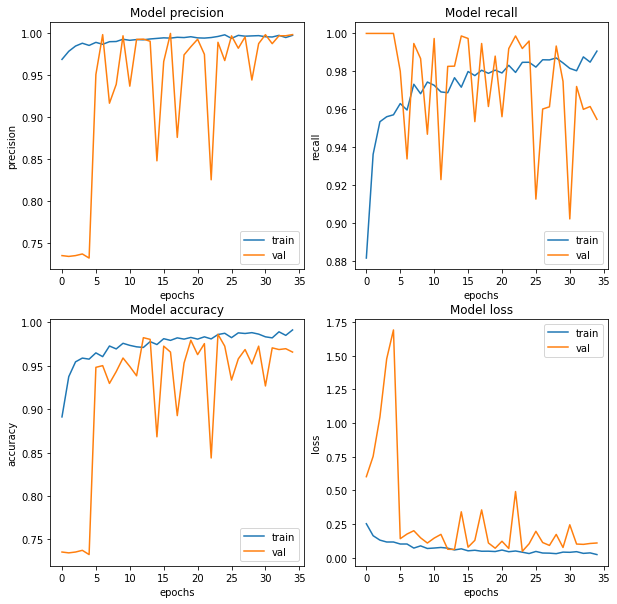

In [22]:
fig, ax = plt.subplots(2, 2, figsize=(10, 10))
ax = ax.ravel()

for i, met in enumerate(['precision', 'recall', 'accuracy', 'loss']):
    ax[i].plot(history.history[met])
    ax[i].plot(history.history['val_' + met])
    ax[i].set_title('Model {}'.format(met))
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(met)
    ax[i].legend(['train', 'val'])

In [23]:
loss, accuracy, precision, recall = model.evaluate(test_ds)
print(f'Loss: {loss},\nAccuracy: {accuracy},\nPrecision: {precision},\nRecall: {recall}')

20/20 [==============================] - 4s 216ms/step - loss: 0.9576 - accuracy: 0.8013 - precision: 0.7671 - recall: 0.9795
Loss: 0.9576082229614258,
Accuracy: 0.8012820482254028,
Precision: 0.7670682668685913,
Recall: 0.9794871807098389


### 👍 정확도: 80.1%

***

### 🧤 성능 개선 (2) batch_size 증가 + epoch 증가 + augmentation + dropout 비율 변경 (82.2%)

- batch_size: 16 -> 32
- epoch: 25 -> 35
- `augment` 함수를 통해 랜덤하게 좌우 반전 시킨다.
- dropout: 0.2 -> 0.5 <br/>

(dropout은 보통 0.2 ~ 0.5로 둔다고 한다.)

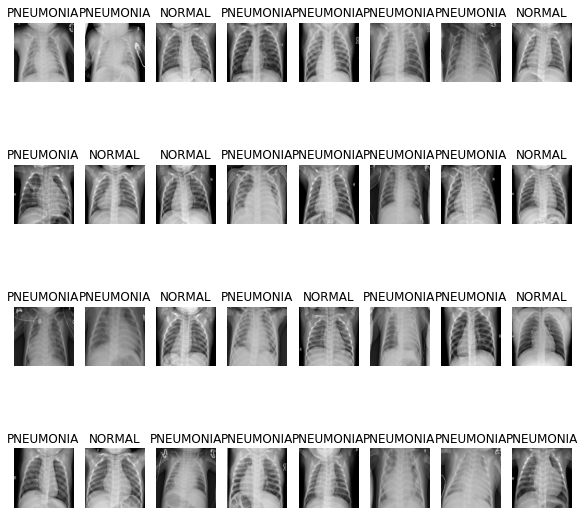

In [24]:
def augment(image,label):
    image = tf.image.random_flip_left_right(image)  # 랜덤하게 좌우를 반전합니다.
    return image,label

def prepare_for_training_aug(ds, shuffle_buffer_size=1000):
    # augment 적용 부분이 배치처리 함수에 추가되었습니다.
    ds = ds.map(
            augment,       # augment 함수 적용
            num_parallel_calls=2
        )
    ds = ds.shuffle(buffer_size=shuffle_buffer_size)  # 고정 크기 버퍼 유지
    ds = ds.repeat() # epoch 진행 시 데이터셋 여러 번 사용 가능
    ds = ds.batch(BATCH_SIZE)
    ds = ds.prefetch(buffer_size=AUTOTUNE) # 다음 연산 데이터 미리 가져오기

    return ds

train_ds_aug2 = prepare_for_training_aug(train_ds)
val_ds_aug2 = prepare_for_training_aug(val_ds)



def dense_block(units, dropout_rate):
    block = tf.keras.Sequential([
        tf.keras.layers.Dense(units, activation='relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dropout(dropout_rate)
    ])
    
    return block


# 이미지 배치를 입력하면 여러 장의 이미지를 보여줌
def show_batch(image_batch, label_batch):
    plt.figure(figsize=(10, 10))
    for n in range(BATCH_SIZE): # BATCH_SIZE=32
        ax = plt.subplot(4, math.ceil(BATCH_SIZE/4), n+1) # (8, 8, n+1)
        plt.imshow(image_batch[n])
        if label_batch[n]: # True면 폐렴
            plt.title("PNEUMONIA")
        else:
            plt.title("NORMAL")
        plt.axis("off")


# train_ds의 label에 True(폐렴)/False(정상) 데이터가 저장되어 있었음.
image_batch_aug2, label_batch_aug2 = next(iter(train_ds_aug2))
show_batch(image_batch_aug2.numpy(), label_batch_aug2.numpy())

In [25]:
def conv_block(filters):
    block = tf.keras.Sequential([
        tf.keras.layers.SeparableConv2D(filters, 3, activation='relu', padding='same'),
        tf.keras.layers.SeparableConv2D(filters, 3, activation='relu', padding='same'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPool2D()
    ])
    
    return block


def build_model():
    model = tf.keras.Sequential([
        tf.keras.Input(shape=(IMAGE_SIZE[0], IMAGE_SIZE[1], 3)),
        
        tf.keras.layers.Conv2D(16, 3, activation='relu', padding='same'),
        tf.keras.layers.Conv2D(16, 3, activation='relu', padding='same'),
        tf.keras.layers.MaxPool2D(),
        
        conv_block(32),
        conv_block(64),
        
        conv_block(128),
        tf.keras.layers.Dropout(0.5), # 변경
        
        conv_block(256),
        tf.keras.layers.Dropout(0.5), # 변경
        
        tf.keras.layers.Flatten(),
        dense_block(512, 0.7),
        dense_block(128, 0.5),
        dense_block(64, 0.3),
        
        tf.keras.layers.Dense(1, activation='sigmoid')
    ])
    
    return model

In [26]:
# 반비례
weight_for_0 = (1 / COUNT_NORMAL) * (TRAIN_IMG_COUNT) / 2.0 
weight_for_1 = (1 / COUNT_PNEUMONIA) * (TRAIN_IMG_COUNT) / 2.0

class_weight = {0: weight_for_0, 1: weight_for_1}

print('Weight for NORMAL: {:.2f}'.format(weight_for_0))
print('Weight for PNEUMONIA: {:.2f}'.format(weight_for_1))

Weight for NORMAL: 1.95
Weight for PNEUMONIA: 0.67


In [27]:
with tf.device('/GPU:0'):
    model2 = build_model()
    
    METRICS = [
        'accuracy',
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall')
    ]
    
    model2.compile(
        optimizer='adam',
        loss='binary_crossentropy',
        metrics=METRICS
    )

In [28]:
with tf.device('/GPU:0'):
    history2 = model2.fit(
        train_ds_aug2,
        steps_per_epoch=TRAIN_IMG_COUNT // BATCH_SIZE,
        epochs=EPOCHS,
        validation_data=val_ds_aug2,
        validation_steps=VAL_IMG_COUNT // BATCH_SIZE,
        class_weight=class_weight,
    )

Epoch 1/35
130/130 [==============================] - 57s 366ms/step - loss: 0.5118 - accuracy: 0.7329 - precision: 0.9242 - recall: 0.6979 - val_loss: 0.5808 - val_accuracy: 0.7324 - val_precision: 0.7324 - val_recall: 1.0000
Epoch 2/35
130/130 [==============================] - 48s 367ms/step - loss: 0.2570 - accuracy: 0.8986 - precision: 0.9720 - recall: 0.8890 - val_loss: 0.7565 - val_accuracy: 0.7314 - val_precision: 0.7314 - val_recall: 1.0000
Epoch 3/35
130/130 [==============================] - 47s 363ms/step - loss: 0.2262 - accuracy: 0.9173 - precision: 0.9722 - recall: 0.9151 - val_loss: 0.9900 - val_accuracy: 0.7373 - val_precision: 0.7373 - val_recall: 1.0000
Epoch 4/35
130/130 [==============================] - 48s 371ms/step - loss: 0.1788 - accuracy: 0.9339 - precision: 0.9802 - recall: 0.9298 - val_loss: 1.2953 - val_accuracy: 0.7344 - val_precision: 0.7344 - val_recall: 1.0000
Epoch 5/35
130/130 [==============================] - 50s 385ms/step - loss: 0.1951 - accura

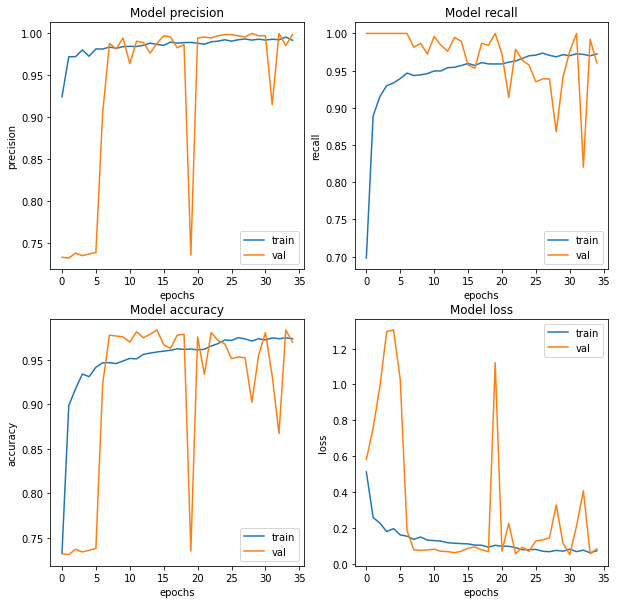

In [29]:
fig, ax = plt.subplots(2, 2, figsize=(10, 10))
ax = ax.ravel()

for i, met in enumerate(['precision', 'recall', 'accuracy', 'loss']):
    ax[i].plot(history2.history[met])
    ax[i].plot(history2.history['val_' + met])
    ax[i].set_title('Model {}'.format(met))
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(met)
    ax[i].legend(['train', 'val'])

In [30]:
loss, accuracy, precision, recall = model2.evaluate(test_ds)
print(f'Loss: {loss},\nAccuracy: {accuracy},\nPrecision: {precision},\nRecall: {recall}')

20/20 [==============================] - 4s 201ms/step - loss: 0.7690 - accuracy: 0.8221 - precision: 0.7830 - recall: 0.9897
Loss: 0.7690404057502747,
Accuracy: 0.8221153616905212,
Precision: 0.7829614877700806,
Recall: 0.9897435903549194


### 👍 정확도: 82.2%

### 🧤 성능 개선 (3) batch_size 증가 + epoch 증가 + augmentation + dropout 비율 변경 + optimizer 변경 (71.7%)

- batch_size: 16->32
- epoch: 25 -> 35
- `augment` 함수를 통해 랜덤하게 좌우 반전 시킨다.
- dropout: 0.2 -> 0.5
- optimizer: 'adam' -> 'rmsprop'

In [37]:
def augment(image,label):
    image = tf.image.random_flip_left_right(image)  # 랜덤하게 좌우를 반전합니다.
    return image,label

def prepare_for_training_aug(ds, shuffle_buffer_size=1000):
    # augment 적용 부분이 배치처리 함수에 추가되었습니다.
    ds = ds.map(
            augment,       # augment 함수 적용
            num_parallel_calls=2
        )
    ds = ds.shuffle(buffer_size=shuffle_buffer_size)  # 고정 크기 버퍼 유지
    ds = ds.repeat() # epoch 진행 시 데이터셋 여러 번 사용 가능
    ds = ds.batch(BATCH_SIZE)
    ds = ds.prefetch(buffer_size=AUTOTUNE) # 다음 연산 데이터 미리 가져오기

    return ds

train_ds_aug3 = prepare_for_training_aug(train_ds)
val_ds_aug3 = prepare_for_training_aug(val_ds)



def dense_block(units, dropout_rate):
    block = tf.keras.Sequential([
        tf.keras.layers.Dense(units, activation='relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dropout(dropout_rate)
    ])
    
    return block


# # 이미지 배치를 입력하면 여러 장의 이미지를 보여줌
# def show_batch(image_batch, label_batch):
#     plt.figure(figsize=(10, 10))
#     for n in range(BATCH_SIZE): # BATCH_SIZE=16
#         ax = plt.subplot(4, math.ceil(BATCH_SIZE/4), n+1) # (4, 4, n+1)
#         plt.imshow(image_batch[n])
#         if label_batch[n]: # True면 폐렴
#             plt.title("PNEUMONIA")
#         else:
#             plt.title("NORMAL")
#         plt.axis("off")


# train_ds의 label에 True(폐렴)/False(정상) 데이터가 저장되어 있었음.
image_batch_aug3, label_batch_aug3 = next(iter(train_ds_aug3))
# show_batch(image_batch_aug3.numpy(), label_batch_aug3.numpy())

In [38]:
def conv_block(filters):
    block = tf.keras.Sequential([
        tf.keras.layers.SeparableConv2D(filters, 3, activation='relu', padding='same'),
        tf.keras.layers.SeparableConv2D(filters, 3, activation='relu', padding='same'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPool2D()
    ])
    
    return block

def dense_block(units, dropout_rate):
    block = tf.keras.Sequential([
        tf.keras.layers.Dense(units, activation='relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dropout(dropout_rate)
    ])
    
    return block

def build_model():
    model = tf.keras.Sequential([
        tf.keras.Input(shape=(IMAGE_SIZE[0], IMAGE_SIZE[1], 3)),
        
        tf.keras.layers.Conv2D(16, 3, activation='relu', padding='same'),
        tf.keras.layers.Conv2D(16, 3, activation='relu', padding='same'),
        tf.keras.layers.MaxPool2D(),
        
        conv_block(32),
        conv_block(64),
        
        conv_block(128),
        tf.keras.layers.Dropout(0.5),
        
        conv_block(256),
        tf.keras.layers.Dropout(0.5),
        
        tf.keras.layers.Flatten(),
        dense_block(512, 0.7),
        dense_block(128, 0.5),
        dense_block(64, 0.3),
        
        tf.keras.layers.Dense(1, activation='sigmoid')
    ])
    
    return model

In [39]:
# 반비례
weight_for_0 = (1 / COUNT_NORMAL) * (TRAIN_IMG_COUNT) / 2.0 
weight_for_1 = (1 / COUNT_PNEUMONIA) * (TRAIN_IMG_COUNT) / 2.0

class_weight = {0: weight_for_0, 1: weight_for_1}

print('Weight for NORMAL: {:.2f}'.format(weight_for_0))
print('Weight for PNEUMONIA: {:.2f}'.format(weight_for_1))

Weight for NORMAL: 1.95
Weight for PNEUMONIA: 0.67


In [40]:
with tf.device('/GPU:0'):
    model3 = build_model()
    
    METRICS = [
        'accuracy',
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall')
    ]
    
    model3.compile(
        optimizer='rmsprop',
        loss='binary_crossentropy',
        metrics=METRICS
    )

In [41]:
with tf.device('/GPU:0'):
    history3 = model3.fit(
        train_ds_aug3,
        steps_per_epoch=TRAIN_IMG_COUNT // BATCH_SIZE,
        epochs=EPOCHS,
        validation_data=val_ds_aug3,
        validation_steps=VAL_IMG_COUNT // BATCH_SIZE,
        class_weight=class_weight,
    )

Epoch 1/35
261/261 [==============================] - 59s 189ms/step - loss: 0.3948 - accuracy: 0.8149 - precision: 0.9485 - recall: 0.7943 - val_loss: 0.7341 - val_accuracy: 0.7356 - val_precision: 0.7356 - val_recall: 1.0000
Epoch 2/35
261/261 [==============================] - 49s 188ms/step - loss: 0.2271 - accuracy: 0.9169 - precision: 0.9697 - recall: 0.9170 - val_loss: 0.9152 - val_accuracy: 0.7375 - val_precision: 0.7375 - val_recall: 1.0000
Epoch 3/35
261/261 [==============================] - 49s 189ms/step - loss: 0.1946 - accuracy: 0.9315 - precision: 0.9725 - recall: 0.9343 - val_loss: 0.4459 - val_accuracy: 0.8346 - val_precision: 1.0000 - val_recall: 0.7746
Epoch 4/35
261/261 [==============================] - 50s 191ms/step - loss: 0.2005 - accuracy: 0.9320 - precision: 0.9706 - recall: 0.9368 - val_loss: 0.6725 - val_accuracy: 0.8067 - val_precision: 1.0000 - val_recall: 0.7373
Epoch 5/35
261/261 [==============================] - 51s 195ms/step - loss: 0.1941 - accura

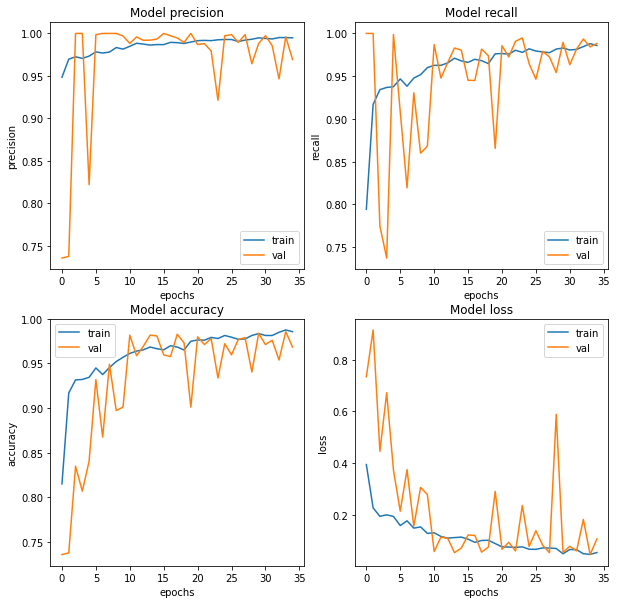

In [42]:
fig, ax = plt.subplots(2, 2, figsize=(10, 10))
ax = ax.ravel()

for i, met in enumerate(['precision', 'recall', 'accuracy', 'loss']):
    ax[i].plot(history3.history[met])
    ax[i].plot(history3.history['val_' + met])
    ax[i].set_title('Model {}'.format(met))
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(met)
    ax[i].legend(['train', 'val'])

In [43]:
loss, accuracy, precision, recall = model3.evaluate(test_ds)
print(f'Loss: {loss},\nAccuracy: {accuracy},\nPrecision: {precision},\nRecall: {recall}')

20/20 [==============================] - 4s 210ms/step - loss: 2.1422 - accuracy: 0.7179 - precision: 0.6904 - recall: 0.9949
Loss: 2.142241954803467,
Accuracy: 0.7179487347602844,
Precision: 0.690391480922699,
Recall: 0.9948717951774597


### 👍 성능: 71.7%
basic 모델보다도 성능이 안 나왔다. optimizer은 원래대로 'adam'을 사용하는 게 좋다고 판단된다.

### 🧤 성능 개선 (4) batch_size 증가 + epoch 증가 + augmentation(좌우 반전/밝기 조정) + dropout 비율 변경 (85.5%)

- batch_size: 16 -> 32
- epoch: 25 -> 35
- `augment` 함수를 통해 랜덤하게 좌우 반전 + 밝기 조정을 한다.
- dropout: 0.2 -> 0.5

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

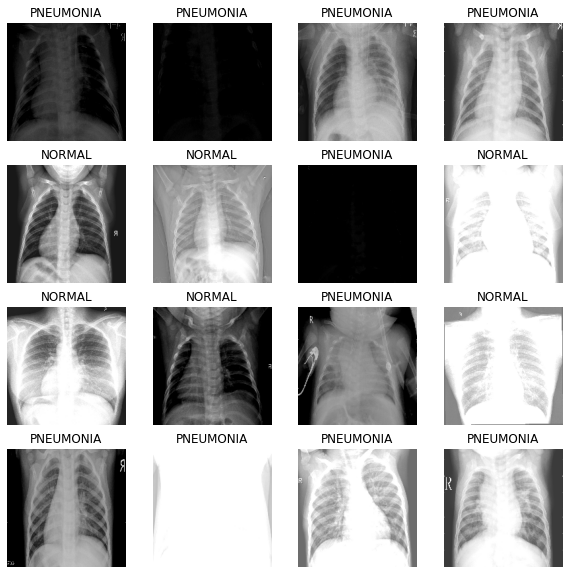

In [60]:
def augment(image,label):
    image = tf.image.random_flip_left_right(image) # 랜덤하게 좌우를 반전합니다.
    image = tf.image.random_brightness(image, 0.8) # 랜덤하게 밝기 조정
    return image,label

def prepare_for_training_aug(ds, shuffle_buffer_size=1000):
    # augment 적용 부분이 배치처리 함수에 추가되었습니다.
    ds = ds.map(
            augment,       # augment 함수 적용
            num_parallel_calls=2
        )
    ds = ds.shuffle(buffer_size=shuffle_buffer_size)  # 고정 크기 버퍼 유지
    ds = ds.repeat() # epoch 진행 시 데이터셋 여러 번 사용 가능
    ds = ds.batch(BATCH_SIZE)
    ds = ds.prefetch(buffer_size=AUTOTUNE) # 다음 연산 데이터 미리 가져오기
    return ds

train_ds_aug4 = prepare_for_training_aug(train_ds)
val_ds_aug4 = prepare_for_training_aug(val_ds)


# 이미지 배치를 입력하면 여러 장의 이미지를 보여줌
def show_batch(image_batch, label_batch):
    plt.figure(figsize=(10, 10))
    for n in range(BATCH_SIZE): # BATCH_SIZE=32
        ax = plt.subplot(4, math.ceil(BATCH_SIZE/4), n+1) # (4, 8, n+1)
        plt.imshow(image_batch[n])
        if label_batch[n]: # True면 폐렴
            plt.title("PNEUMONIA")
        else:
            plt.title("NORMAL")
        plt.axis("off")

# train_ds의 label에 True(폐렴)/False(정상) 데이터가 저장되어 있었음.
image_batch_aug4, label_batch_aug4 = next(iter(train_ds_aug4))
show_batch(image_batch_aug4.numpy(), label_batch_aug4.numpy())

In [61]:
def conv_block(filters):
    block = tf.keras.Sequential([
        tf.keras.layers.SeparableConv2D(filters, 3, activation='relu', padding='same'),
        tf.keras.layers.SeparableConv2D(filters, 3, activation='relu', padding='same'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPool2D()
    ])
    
    return block

def dense_block(units, dropout_rate):
    block = tf.keras.Sequential([
        tf.keras.layers.Dense(units, activation='relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dropout(dropout_rate)
    ])
    
    return block


def build_model():
    model = tf.keras.Sequential([
        tf.keras.Input(shape=(IMAGE_SIZE[0], IMAGE_SIZE[1], 3)),
        
        tf.keras.layers.Conv2D(16, 3, activation='relu', padding='same'),
        tf.keras.layers.Conv2D(16, 3, activation='relu', padding='same'),
        tf.keras.layers.MaxPool2D(),
        
        conv_block(32),
        conv_block(64),
        
        conv_block(128),
        tf.keras.layers.Dropout(0.5), # 변경
        
        conv_block(256),
        tf.keras.layers.Dropout(0.5), # 변경
        
        tf.keras.layers.Flatten(),
        dense_block(512, 0.7),
        dense_block(128, 0.5),
        dense_block(64, 0.3),
        
        tf.keras.layers.Dense(1, activation='sigmoid')
    ])
    
    return model

# 반비례
weight_for_0 = (1 / COUNT_NORMAL) * (TRAIN_IMG_COUNT) / 2.0 
weight_for_1 = (1 / COUNT_PNEUMONIA) * (TRAIN_IMG_COUNT) / 2.0

class_weight = {0: weight_for_0, 1: weight_for_1}

# print('Weight for NORMAL: {:.2f}'.format(weight_for_0))
# print('Weight for PNEUMONIA: {:.2f}'.format(weight_for_1))

In [62]:
with tf.device('/GPU:0'):
    model4 = build_model()
    
    METRICS = [
        'accuracy',
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall')
    ]
    
    model4.compile(
        optimizer='adam',
        loss='binary_crossentropy',
        metrics=METRICS
    )

In [63]:
with tf.device('/GPU:0'):
    history4 = model4.fit(
        train_ds_aug4,
        steps_per_epoch=TRAIN_IMG_COUNT // BATCH_SIZE,
        epochs=EPOCHS,
        validation_data=val_ds_aug4,
        validation_steps=VAL_IMG_COUNT // BATCH_SIZE,
        class_weight=class_weight,
    )

Epoch 1/35
261/261 [==============================] - 56s 184ms/step - loss: 0.8664 - accuracy: 0.5196 - precision: 0.7622 - recall: 0.5148 - val_loss: 0.8513 - val_accuracy: 0.2644 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 2/35
261/261 [==============================] - 48s 182ms/step - loss: 0.7886 - accuracy: 0.5050 - precision: 0.7506 - recall: 0.5016 - val_loss: 0.8027 - val_accuracy: 0.2692 - val_precision: 1.0000 - val_recall: 0.0052
Epoch 3/35
261/261 [==============================] - 47s 181ms/step - loss: 0.7584 - accuracy: 0.5017 - precision: 0.7388 - recall: 0.5089 - val_loss: 0.7981 - val_accuracy: 0.3462 - val_precision: 0.8000 - val_recall: 0.1466
Epoch 4/35
261/261 [==============================] - 49s 187ms/step - loss: 0.7245 - accuracy: 0.5103 - precision: 0.7525 - recall: 0.5109 - val_loss: 0.7043 - val_accuracy: 0.4317 - val_precision: 0.8050 - val_recall: 0.2975
Epoch 5/35
261/261 [==============================] - 50s 190ms/step - loss: 0.7170 

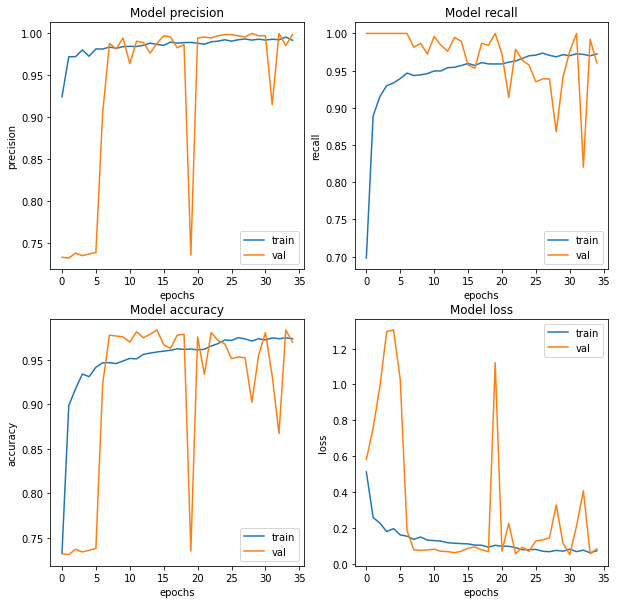

In [64]:
fig, ax = plt.subplots(2, 2, figsize=(10, 10))
ax = ax.ravel()

for i, met in enumerate(['precision', 'recall', 'accuracy', 'loss']):
    ax[i].plot(history2.history[met])
    ax[i].plot(history2.history['val_' + met])
    ax[i].set_title('Model {}'.format(met))
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(met)
    ax[i].legend(['train', 'val'])

In [65]:
loss, accuracy, precision, recall = model4.evaluate(test_ds)
print(f'Loss: {loss},\nAccuracy: {accuracy},\nPrecision: {precision},\nRecall: {recall}')

20/20 [==============================] - 4s 194ms/step - loss: 0.4244 - accuracy: 0.8558 - precision: 0.8233 - recall: 0.9795
Loss: 0.42443862557411194,
Accuracy: 0.8557692170143127,
Precision: 0.8232758641242981,
Recall: 0.9794871807098389


### 👍 성능: 85.5%
추가적으로 밝기 조절 augmentation을 해주었더니 성능 향상!

***

## 🧤 회고

data augmentation을 다뤄볼 수 있는 재밌는 노드였다. 

### ✔️ 기본 모델 실습 결과
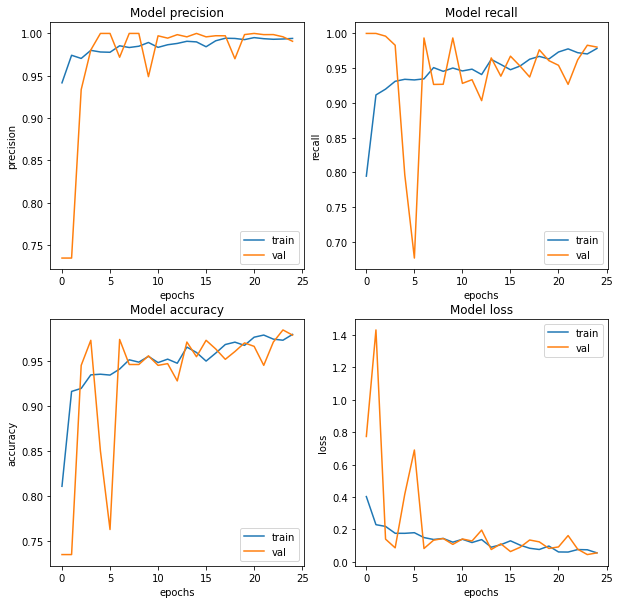
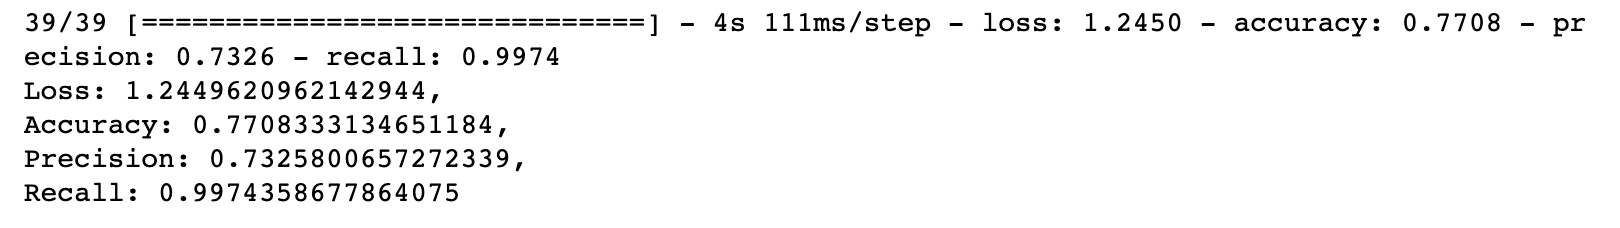

### ✔️ 최종 성능 (Accuracy / Recall)
- 기본 모델: 77% / 99.7% <br/>

(+) 공통적으로 batch_size 증가 + epoch 증가 + 좌우 반전 augmentation을 추가 적용함
1) dropout 미사용: 80% / 97.9% <br/>
2) dropout 비율 증가: 82.2% / 98.9% <br/>
3) dropout 비율 증가 + optimizer='rmsprop': 71% / 99.4% <br/>
4) 밝기 조절 augmentation + dropout 비율증가: 85.5% / 97.9%
<br/>

#### 🐥 밝기 조절 augmentation을 추가한 모델이 85.5%로 성능이 가장 높게 나옴

***

- 데이터 증강을 통해 데이터가 많아진만큼 batch size를 크게 잡았다.

- 의료 영상 분석 문제라 data augmentation을 함부로 하면 안 될 것 같아 처음엔 예시에 나온대로 좌우 반전 augmentation 부분만 추가를 했었다. 그러다 궁금해져서 색상을 변화시키는 항을 추가해보았는데 놀랍게도 성능이 좋게 나왔다. 이 예제는 흉부의 xray이므로 상하 반전은 진행하지 않았다. data augmentation의 효과를 직접적으로 볼 수 있는 노드여서 흥미로웠다.

- 더 다양하게 조정해 성능을 90% 이상으로 늘리고 싶었지만 시간 관계상 어려운 부분이었다.

- epoch를 크게 잡아 early stopping을 적용해보고 싶었는데 그래프에서 볼 수 있다시피 val acc가 큰 폭으로 요동치는 부분이 많았다. 아무 것도 적용하지 않는 base model에서보다 augmentation을 적용한 모델에서 크게 나왔는데 증강을 하게 되는 경우 너무 적은 epoch를 돌리면 성능이 안 좋게 나올 수 있다고 판단된다. 

- 데이터 양이 많아져 dropout을 크게 하는 것이 더 성능을 좋게 만든것인가 해석된다.

- optimizer은 예상 외로 'rmsprop'보다 'adam'에서 성능이더 잘 나왔다.

- 